<a target="_blank" href="https://colab.research.google.com/github/NX-AI/tirex/blob/main/examples/tirex_onnx.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Quick Start In Colab"/>
</a>

# Tirex ONNX model

Note that this version might not give the exact same results as the toch version, as a bfloat16 matmul isn't currently implemented in onnx: https://github.com/microsoft/onnxruntime/issues/26311

In [1]:
# For running the onnx model:
!pip install -q numpy onnxruntime huggingface_hub
# For plotting and loading data:
!pip install -q pandas tirex-ts matplotlib scikit-learn

In [ ]:
import math
import os

import numpy as np
import onnxruntime


class TiRexONNX:
    def __init__(
        self,
        model_path: str | os.PathLike,
        providers: list[str] | None = None,
        sess_options: onnxruntime.SessionOptions | None = None,
    ) -> None:
        self.onnx_session = onnxruntime.InferenceSession(model_path, sess_options, providers)

    def forecast(self, context: np.ndarray, prediction_length: int) -> tuple[np.ndarray, np.ndarray]:
        max_context_length = 2048
        predictions = []

        for _ in range(math.ceil(prediction_length / 32)):
            if context.shape[-1] > max_context_length:
                context = context[..., -max_context_length:]
            prediction = self.onnx_session.run(None, {"context": context.astype(np.float32)})[0]
            predictions.append(prediction)
            context = np.concatenate([context, np.full_like(prediction[:, :, 0], fill_value=np.nan)], axis=-1)

        quantiles = np.concatenate(predictions, axis=1)[..., :prediction_length].astype(np.float32)
        median = quantiles[:, :, 4]
        return quantiles, median

    @staticmethod
    def from_pretrained(
        hf_repo_id="NX-AI/TiRex",
        model_id="tirex.onnx",
        providers: list[str] | None = None,
        sess_options: onnxruntime.SessionOptions | None = None,
    ):
        from huggingface_hub import hf_hub_download

        model_path = hf_hub_download(repo_id=hf_repo_id, filename=model_id)
        return TiRexONNX(model_path, providers, sess_options)

In [3]:
import pandas as pd

data_base_url = "https://raw.githubusercontent.com/NX-AI/tirex/refs/heads/main/tests/data/"
data_long = pd.read_csv(f"{data_base_url}/loop_seattle_5T.csv").values.reshape(-1)
ctx_l, future_l = np.split(data_long, [-512])

context_onnx = ctx_l.reshape(1, -1).astype(np.float32)  # Reshape to add batch dimension: (length,) -> (1, length)

In [4]:
onnx_inference = TiRexONNX.from_pretrained("NX-AI/TiRex")
quantiles, median = onnx_inference.forecast(context_onnx, prediction_length=768)

/home/martin/space/tirex-internal/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

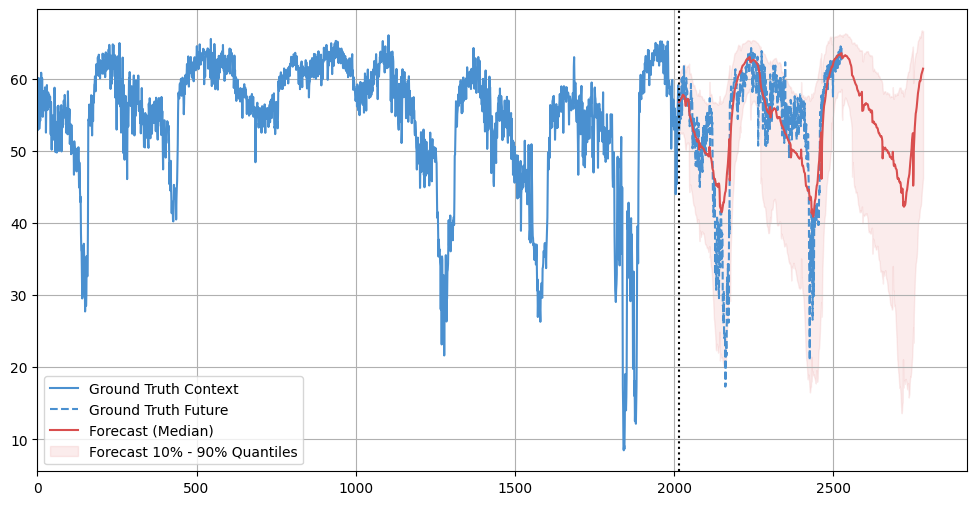

In [5]:
import matplotlib.pyplot as plt

from tirex.util import plot_forecast

plt.rcParams["figure.figsize"] = (12, 6)

plot_forecast(ctx_l, quantiles[0], future_l)

In [6]:
# Run onnx model with custom session options

# ONNX Parameters: see https://onnxruntime.ai/docs/api/python/api_summary.html#sessionoptions
sess_options = onnxruntime.SessionOptions()
sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
sess_options.intra_op_num_threads = 10
sess_options.inter_op_num_threads = 1

# On which device to run: in our case on CPU version
providers = ["CPUExecutionProvider"]

model_optimized = TiRexONNX.from_pretrained("NX-AI/TiRex", providers=providers, sess_options=sess_options)

quantiles_opt, median_opt = model_optimized.forecast(context_onnx, prediction_length=768)
quantiles_opt.shape, median_opt.shape

((1, 768, 9), (1, 768))